<a href="https://colab.research.google.com/github/Sandeep-4469/ML_Project/blob/main/Project_K_(Paper_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps for Implementation

1. **Data Collection**
   - Obtain the dataset (e.g., from Kaggle) that contains hourly electricity demand from May 2005 to August 2018.

2. **Data Loading**
   - Load the dataset using a library like Pandas.
   - Convert the datetime column to a proper datetime format and set it as the index.

3. **Feature Engineering**
   - Extract relevant features from the datetime column:
     - Day of the year
     - Day of the month
     - Day of the week
     - Hour of the day
     - Month
     - Year

4. **Data Preparation**
   - Create a feature matrix from the extracted features.
   - Define the target variable (electricity demand).

5. **Data Normalization**
   - Use Min-Max normalization to scale the features and target variable to a range of [0, 1].

6. **Data Splitting**
   - Split the dataset into training (80%) and testing (20%) sets.

7. **Modeling with XGBoost**
   - Initialize and configure an XGBoost regression model.
   - Fit the model using the training data.
   - Make predictions on the test set and visualize the results.

8. **Modeling with RNN**
   - Reshape the training and testing data for RNN input.
   - Build and configure a simple RNN model.
   - Train the RNN model using the training data.
   - Make predictions and visualize the results.

9. **Modeling with LSTM**
   - Reshape the training and testing data for LSTM input.
   - Build and configure an LSTM model.
   - Train the LSTM model using the training data.
   - Make predictions and visualize the results.

10. **Evaluation**
    - Compare the performance of the three models (XGBoost, RNN, LSTM) based on the predicted values against the true values.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout

import xgboost as xgb

In [2]:
!wget -O data.csv https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1&st=25jsg22t&dl=1

--2024-10-14 08:58:03--  https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc304cd3cfa6c563f54a74c848b9.dl.dropboxusercontent.com/cd/0/inline/CcaAGdljBqnXmwnnL-UBpefctGsO6DB5R_znV1xW3pa7NmeMvGPV4pN3e2MppyqE1qBw9igB9Px4UAUqkaPdkAL-voSd6bVUVhKPPQlOYEoWZjQYpadFkQ8Yq-20F4Rf6nJ_VvWkxiTIMw058eDt4E5s/file# [following]
--2024-10-14 08:58:04--  https://uc304cd3cfa6c563f54a74c848b9.dl.dropboxusercontent.com/cd/0/inline/CcaAGdljBqnXmwnnL-UBpefctGsO6DB5R_znV1xW3pa7NmeMvGPV4pN3e2MppyqE1qBw9igB9Px4UAUqkaPdkAL-voSd6bVUVhKPPQlOYEoWZjQYpadFkQ8Yq-20F4Rf6nJ_VvWkxiTIMw058eDt4E5s/file
Resolving uc304cd3cfa6c563f54a74c848b9.dl.dropboxusercontent.com (uc304cd3cfa6c563f54a74c848b9.dl.dropboxusercontent.com)... 162.125.1.15, 2620

In [3]:
data = pd.read_csv('data.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

In [4]:
data['day_of_year'] = data.index.dayofyear
data['day_of_month'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['month'] = data.index.month
data['year'] = data.index.year

In [5]:
features = data[['day_of_year', 'day_of_month', 'day_of_week', 'hour', 'month', 'year']]
target = data['DOM_MW'].values

In [6]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))

In [7]:
split_index = int(len(features_scaled) * 0.8)

X_train, X_test = features_scaled[:split_index], features_scaled[split_index:]
y_train, y_test = target_scaled[:split_index], target_scaled[split_index:]


In [30]:
def create_sequences(X, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(X[i + time_steps])
    return np.array(Xs), np.array(ys)

In [31]:
TIME_STEPS = 20
X_seq, y_seq = create_sequences(target_scaled, TIME_STEPS)

In [33]:
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

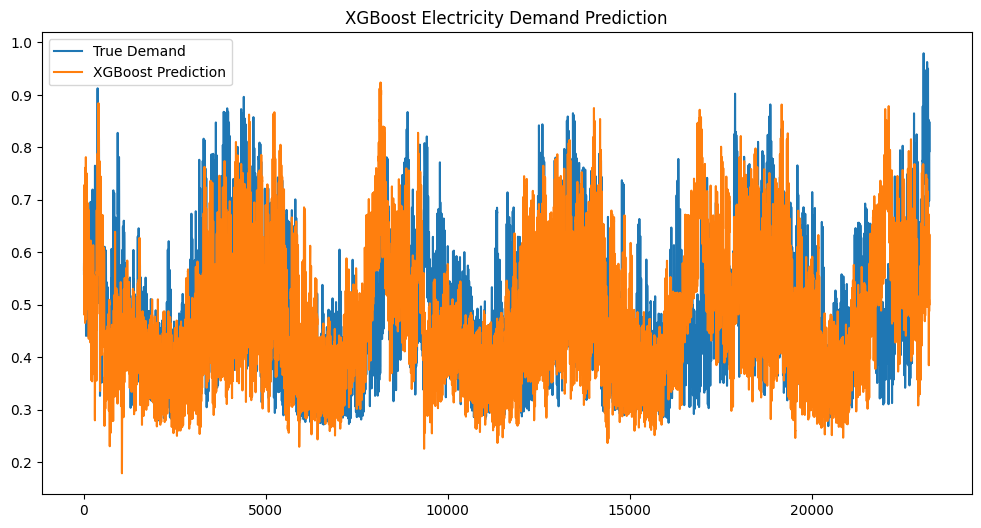

In [34]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.3, max_depth=6, reg_lambda=1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Demand')
plt.plot(xgb_pred, label='XGBoost Prediction')
plt.title('XGBoost Electricity Demand Prediction')
plt.legend()
plt.show()

##RNN model

In [35]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(TIME_STEPS, X_train_seq.shape[2])))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40, activation='tanh'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)
rnn_predictions = rnn_model.predict(X_test_seq)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2905/2905 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 0.0384
Epoch 2/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0013
Epoch 3/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 6.4876e-04
Epoch 4/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 5.8803e-04
Epoch 5/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - loss: 5.8380e-04
Epoch 6/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 5.7287e-04
Epoch 7/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 5.7846e-04
Epoch 8/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 5.8160e-04
Epoch 9/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 5.7952e-04
Epoch 10/10
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 5.4852e-04
727/727 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [36]:
lstm_model = Sequential()
lstm_model.add(LSTM(60, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], 1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation='tanh'))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=32, verbose=1)
lstm_predictions = lstm_model.predict(X_test_seq)

Epoch 1/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 0.0102
Epoch 2/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 9.8131e-04
Epoch 3/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 5.8936e-04
Epoch 4/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 5.1511e-04
Epoch 5/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 4.9539e-04
Epoch 6/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 4.7372e-04
Epoch 7/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 4.5304e-04
Epoch 8/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 4.3441e-04
Epoch 9/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 4.2642e-04
Epoch 10/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 4.1613e-04
Epoch 11/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 3.7679e-04
Epoch 12/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 3.8174e-04
Epoch 13/30
2905/2905 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 3.7199e-04
Epoch 14/30
2905/2905 ━━━━━━━━━━━━━━━━

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred_xgboost_flat = xgb_pred.flatten()
y_pred_lstm_flat = lstm_predictions.flatten()
y_pred_rnn_flat = rnn_predictions.flatten()
metrics = {
    'Model': ['XGBoost', 'LSTM', 'RNN'],
    'Mean Absolute Error (MAE)': [
        mean_absolute_error(y_test, xgb_pred),
        mean_absolute_error(y_test_seq, y_pred_lstm_flat),
        mean_absolute_error(y_test_seq, y_pred_rnn_flat)
    ],
    'Mean Squared Error (MSE)': [
        mean_squared_error(y_test, xgb_pred),
        mean_squared_error(y_test_seq, y_pred_lstm_flat),
        mean_squared_error(y_test_seq, y_pred_rnn_flat)
    ],
    'R-squared (R²)': [
        r2_score(y_test, xgb_pred),
        r2_score(y_test_seq, y_pred_lstm_flat),
        r2_score(y_test_seq, y_pred_rnn_flat)
    ]
}

evaluation_metrics = pd.DataFrame(metrics)


In [39]:
evaluation_metrics

,Model,Mean Absolute Error (MAE),Mean Squared Error (MSE),R-squared (R²)
0,XGBoost,0.077406,0.011428,0.229949
1,LSTM,0.008679,0.000246,0.983392
2,RNN,0.015819,0.000515,0.965289


##Predictions for 2 weeks

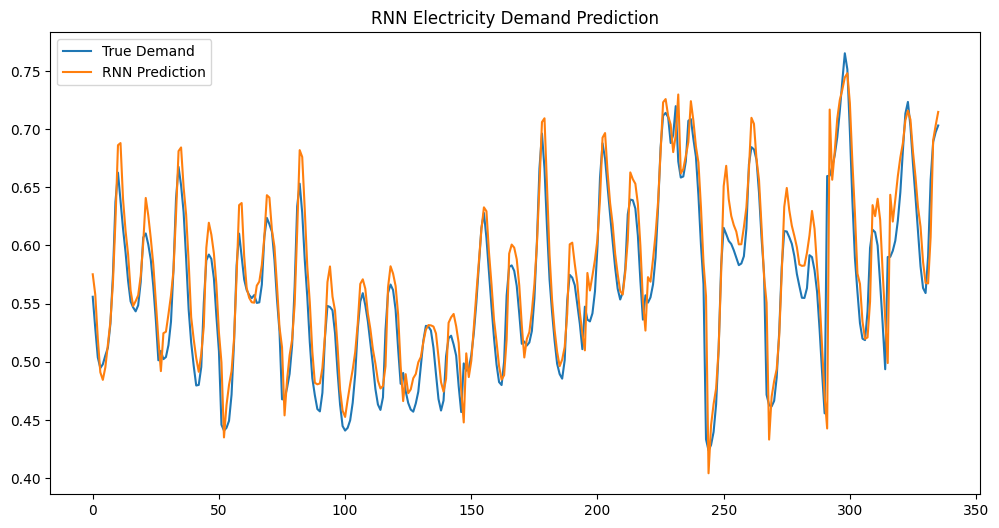

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:24*14], label='True Demand')
plt.plot(y_pred_rnn_flat[:24*14], label='RNN Prediction')
plt.title('RNN Electricity Demand Prediction')
plt.legend()
plt.show()

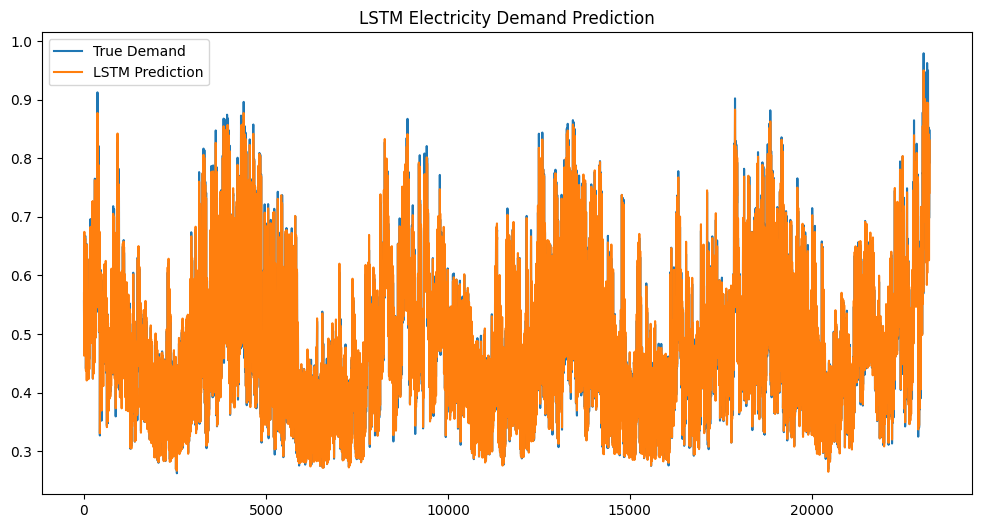

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='True Demand')
plt.plot(y_pred_lstm_flat, label='LSTM Prediction')
plt.title('LSTM Electricity Demand Prediction')
plt.legend()
plt.show()